In [ ]:
# Чтобы воспроизвести результат, нужно запустить ячейки в порядке их номеров, указынных в первой строке комментариев.
# Файлы с данными должны быть в той же папке, что и ноутбук, результат запишется в out.csv.
# random_seed я не фиксировал, так что финальные результаты могут немного отличаться

In [1]:
# 1.

import pandas as pd
import numpy as np
import math

In [2]:
# 2. Добавление базовых признаков:
#
# - is_econom, is_business, is_vip - есть ли эконом/бизнес/вип среди выбранных классов машин
# - time_sec - время в секундах от начала суток
# - weekday - день недели
# - is_red - является ли день нерабочим
# 
# Отавляем без изменения признаки:
#
# - lat
# - lon
# - dist
#
# Добавляем признак time (дата + час), он будет использоваться в дальнейшем для join'ов (не не для обучения)
#

def add_features_common(data):
    
    data["is_econom"] = (data["f_class"] == 'econom') | (data["s_class"] == 'econom') | (data["t_class"] == 'econom')
    data["is_business"] = (data["f_class"] == 'business') | (data["s_class"] == 'business') | (data["t_class"] == 'business')
    data["is_vip"] = (data["f_class"] == 'vip') | (data["s_class"] == 'vip') | (data["t_class"] == 'vip')
    
    data["due_dt"] = pd.to_datetime(data["due"])
    data["weekday"] = data["due_dt"].dt.weekday
    data["time_sec"] = data["due_dt"].dt.hour * 3600 + data["due_dt"].dt.minute * 60 + data["due_dt"].dt.second    

    data["is_red"] = data["due_dt"].dt.strftime("%Y-%m-%d").isin(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04', 
        '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-11', '2014-01-12', '2014-01-18', '2014-01-19', 
        '2014-01-25', '2014-01-26', '2014-02-01', '2014-02-02', '2014-02-08', '2014-02-09', '2014-02-15', '2014-02-16',
        '2014-02-22', '2014-02-23', '2014-03-01', '2014-03-02', '2014-03-08', '2014-03-09', '2014-03-10', '2014-03-15', 
        '2014-03-16', '2014-03-22', '2014-03-23', '2014-03-29', '2014-03-30'])
    
    data['time'] = data["due_dt"].dt.floor("H")
    data['due'] = pd.to_datetime(data['due'])
    data.sort_values(by='due', inplace=True)
    data = data.assign(sec_before_next_recurring_order=data.groupby(by=['dist', 'lat', 'lon']).due.diff(-1).dt.total_seconds())

    data = data.sort_index()
    
    data.drop(columns=['due','f_class', 's_class', 't_class'], inplace=True)
    
    return data

In [3]:
# 3. Добавление признаков принадлежности к городу и расстояния от его цента:
#
# - dist_MSK, dist_SPB, dist_NN, dist_KAZ, dist_VRN - расстояния до центров городов
# - is_MSK, is_SPB, is_NN, is_KAZ, is_VRN - принадлежность к городам
#

def add_features_towns(data):
    
    towns = [
        {'town': 'MSK', 'lat': 55.754011, 'lon': 37.620816, 'rad': 25000.0, 'waeather-file': 'group-city-moscow.jsonl'},
        {'town': 'SPB', 'lat': 59.938924, 'lon': 30.315311, 'rad': 20000.0, 'waeather-file': 'group-city-spb.jsonl'},
        {'town': 'NN', 'lat': 56.328413, 'lon': 44.003331, 'rad': 15000.0, 'waeather-file': 'group-city-nnovgorod.jsonl'},
        {'town': 'KAZ', 'lat': 55.797400, 'lon':49.106930, 'rad': 25000.0, 'waeather-file': 'group-city-kazan.jsonl'},
        {'town': 'VRN', 'lat': 51.660746, 'lon': 39.199609, 'rad': 10000.0, 'waeather-file': 'group-city-voronezh.jsonl'}
    ]
    
    data['town'] = 'UNK'
    
    for t in towns:
        data['cosd_' + t['town']] = data['lat'].apply(lambda x: math.sin(x / 90.0)) * math.sin(t['lat'] / 90.0) + \
            data['lat'].apply(lambda x: math.cos(x / 90.0)) * math.cos(t['lat'] / 90.0) * \
            data['lon'].apply(lambda x: math.cos(x / 90.0 - t['lon'] / 90.0))
        data['dist_' + t['town']] = data['cosd_' + t['town']].apply(lambda x: math.acos(math.fabs(x))) * 6371000
        data['is_' + t['town']] = data['dist_' + t['town']] <= t['rad']
        data.loc[data['is_' + t['town']], 'town'] = t['town']
        data.drop(columns=['cosd_' + t['town']], inplace=True)
        
    return data

In [94]:
# этот код не используется, запускать не нужно
# первый (устаревший) вариант copies 

# m_to_lat = 0.000008985
# m_to_lon = 0.000015964
# data['lat_sq'] = int(data['lat'] / (10 * m_to_lat))
# data['lon_sq'] = int(data['lon'] / (10 * m_to_lon))

# copies = data[['lat_sq','lon_sq','time_h','due']].groupby(['lat_sq','lon_sq','time_h']).count().rename(columns={"due": "copies"})
# data = data.merge(copies, on = ['lat_sq','lon_sq','time_h'], how = 'left')

# ##

In [4]:
# 4. Добавление признаков, основанных на распозновании дублирующихся вызовов - вызовов примерно в одну и ту же точку, 
# примерно в обно и то же время.
#
# copies_* - количество копий (вызовов в тот же квадрат в тот же час)
# copies_delta_min_t_* - время вызова относительно времени самой ранней копии
# copies_delta_max_t_* - время вызова относительно времени самой поздней копии
#
# копии (и соответсвующие признаки) определяются по 10 разным сеткам, они отличаются:
# - длиной стороны квадрата: 1, 10, 30, 90, 270 метров
# - наличием сдвига (на полчаса по времени и на полстороны квадрата по осям)
# 


def add_features_copies(data):

    conf_copies_features = [
        {'name': '1m', 'lat_m': 1, 'lon_m': 1, 'lat_shift': 0, 'lon_shift': 0, 'time_shift': 0},
        {'name': '1m_shifted', 'lat_m': 1, 'lon_m': 1, 'lat_shift': 0.5, 'lon_shift': 0.5, 'time_shift': 30},
        {'name': '10m', 'lat_m': 10, 'lon_m': 10, 'lat_shift': 0, 'lon_shift': 0, 'time_shift': 0},
        {'name': '10m_shifted', 'lat_m': 10, 'lon_m': 10, 'lat_shift': 0.5, 'lon_shift': 0.5, 'time_shift': 30},
        {'name': '30m', 'lat_m': 30, 'lon_m': 30, 'lat_shift': 0, 'lon_shift': 0, 'time_shift': 0},
        {'name': '30m_shifted', 'lat_m': 30, 'lon_m': 30, 'lat_shift': 0.5, 'lon_shift': 0.5, 'time_shift': 30},
        {'name': '90m', 'lat_m': 90, 'lon_m': 90, 'lat_shift': 0, 'lon_shift': 0, 'time_shift': 0},
        {'name': '90m_shifted', 'lat_m': 90, 'lon_m': 90, 'lat_shift': 0.5, 'lon_shift': 0.5, 'time_shift': 30},
        {'name': '270m', 'lat_m': 270, 'lon_m': 270, 'lat_shift': 0, 'lon_shift': 0, 'time_shift': 0},
        {'name': '270m_shifted', 'lat_m': 270, 'lon_m': 270, 'lat_shift': 0.5, 'lon_shift': 0.5, 'time_shift': 30}
    ]
    
    m_to_lat = 0.000008985
    m_to_lon = 0.000015964    
    
    for conf in conf_copies_features:
        lat_delta = m_to_lat * conf['lat_m']
        lon_delta = m_to_lon * conf['lon_m']
    
        group_columns = ['time_group', 'lat_group', 'lon_group']
        select_columns = ['time_group', 'lat_group', 'lon_group', 'due_dt']
        
        data['time_group'] = (data["due_dt"] + pd.Timedelta(minutes=conf['time_shift'])).dt.floor("H")
        data['lat_group'] = data['lat'].apply(lambda x: int(x / lat_delta + conf['lat_shift']))
        data['lon_group'] = data['lon'].apply(lambda x: int(x / lon_delta + conf['lon_shift']))

        copies = data[select_columns].groupby(group_columns).count().rename(columns={"due_dt": "copies_" + conf['name']})
        copies_max_t = data[select_columns].groupby(group_columns).max().rename(columns={"due_dt": "copies_max_t_" + conf['name']})
        copies_min_t = data[select_columns].groupby(group_columns).min().rename(columns={"due_dt": "copies_min_t_" + conf['name']})

        data = data.merge(copies, on = group_columns, how = 'left')
        data = data.merge(copies_max_t, on = group_columns, how = 'left')
        data = data.merge(copies_min_t, on = group_columns, how = 'left')
        
        data['copies_delta_min_t_' + conf['name']] = (data['due_dt'] - data['copies_min_t_' + conf['name']]).dt.total_seconds()
        data['copies_delta_max_t_' + conf['name']] = (data['due_dt'] - data['copies_max_t_' + conf['name']]).dt.total_seconds()
        
        data.drop(columns=['copies_min_t_' + conf['name'], 'copies_max_t_' + conf['name']], axis=1, inplace=True)
        data.drop(columns=group_columns, axis=1, inplace=True)
    
    return data

In [5]:
# 5. Итоговая функция подготовки данных
# Добавление признаков из функций выше и удаление аномалий (данных за 1 января и 24 февраля)

def prepare_data(data):

    data = add_features_common(data)
    data = add_features_towns(data)
    data = add_features_copies(data)
    
    #удаляем из выборки данные за 1 января и 24 февраля
    data = data[data["due_dt"].dt.strftime("%Y-%m-%d") != '2014-01-01']
    data = data[data["due_dt"].dt.strftime("%Y-%m-%d") != '2014-02-24']
    
    return data

In [13]:
# 6. Загрузка данных и их подготовка

data = pd.read_csv('train.csv', sep=',')
data_final_test = pd.read_csv('test.csv', sep=',')

In [14]:
data = prepare_data(data)
data_final_test = prepare_data(data_final_test)

In [ ]:
# type(data)

pandas.core.frame.DataFrame

In [15]:
# 7. Отделяем от train-данных 30% для тестирования (разделение производим по времени)

# -------- prepare train | test | val ---------

train_size = int(0.7 * data.shape[0])
data_train = data.iloc[:train_size].copy()
data_test = data.iloc[train_size:].copy()
# ---------------------------------------

In [100]:
# # 8. Функция добавления признакон на основе KNN:
# # - knn_K - количество отмененных заказов среди K ближайших соседей, соседство определяется по lat и lon с помощью 
# #     евклидовой метрики, для train-выборки K ближайших соседей определяются без учета самой точки 
# # - knn_K_dist - среднее расстояние до K ближайших соседей

# from sklearn.neighbors import NearestNeighbors

# def add_knn_features(data_train, data_test, k_list):
#     # немного двигаем все точки, чтобы ближайшим соседом любой точки из train-выборки была она сама
#     data_train['lat'] = data_train['lat'].apply(lambda x: x + np.random.rand()/100000.0)
#     data_train['lon'] = data_train['lon'].apply(lambda x: x + np.random.rand()/100000.0)    
#     # домножаем долготу на коссинус широты Москвы, чтобы евклидова метрика была более корректной 
#     data_train['lon1'] = data_train['lon'] * 0.5628
#     data_test['lon1'] = data_test['lon'] * 0.5628
    
#     data_test['target1'] = 0
#     NN = NearestNeighbors(n_neighbors=k_list.max()+1, metric='euclidean', n_jobs=-1)
#     NN.fit(data_train[['lat', 'lon1']], data_train['target'])
#     for k in k_list:
#         # для train-выборки берем k+1 ближайшего соседа и вычитаем саму точку
#         dist_train, n_train = NN.kneighbors(data_train[['lat', 'lon1']], n_neighbors=k+1, return_distance=True)
#         data_train['knn_' + str(k)] = pd.Series(data_train['target'].values[n_train].sum(axis=1) - data_train['target'])
#         data_train['knn_' + str(k) + '_dist'] = dist_train.sum(axis=1) / k
#         # для test-выборки просто берем k ближайших соседей
#         dist_test, n_test = NN.kneighbors(data_test[['lat', 'lon1']], n_neighbors=k, return_distance=True)
#         data_test['knn_' + str(k)] = pd.Series(data_train['target'].values[n_test].sum(axis=1) - data_test['target1'])
#         data_test['knn_' + str(k) + '_dist'] = dist_test.sum(axis=1) / k
    
#     return data_train, data_test

In [101]:
# # 9. Добавляенм к данным KNN-признаки для k = 1, 2, 3, 5, 7, 10, 15
# kk = np.array([1, 2, 3, 5, 7, 10, 15])
# data_train, data_test = add_knn_features(data_train, data_test, kk)
# data, data_final_test = add_knn_features(data, data_final_test, kk)

In [16]:
# 10. Формируем финальный список признаков для обучения:
#  удаляем из списка всех столбцов дату, промежуточные служебные поля и поле target 

feature_columns = list(data.columns)
feature_columns.remove('due_dt')
feature_columns.remove('time')
feature_columns.remove('town')
feature_columns.remove('target')

target_column = ['target']

In [ ]:
# полный список полей
feature_columns

In [17]:
# # 11. Проверка работы алгоритма для learning_rate=0.1

# from sklearn.metrics import roc_auc_score
# from lightgbm import LGBMClassifier

# for n_estimators in range(100, 1100, 100):
#     clf = LGBMClassifier(n_estimators=n_estimators, learning_rate=0.1)
#     clf.fit(data_train[feature_columns], data_train[target_column].values.ravel())
    
#     predictions = clf.predict_proba(data_test[feature_columns])
#     auc_score = roc_auc_score(data_test[target_column].values.ravel(), predictions[:, 1])
#     print('score = ', auc_score, ', n_estimators = ', n_estimators)

In [ ]:
# # 12. Проверка работы алгоритма для learning_rate=0.05 и подбор оптимального значения n_estimators

# for n_estimators in range(300, 3300, 300):
#     clf = LGBMClassifier(n_estimators=n_estimators, learning_rate=0.05)
#     clf.fit(data_train[feature_columns], data_train[target_column].values.ravel())
    
#     predictions = clf.predict_proba(data_test[feature_columns])
#     auc_score = roc_auc_score(data_test[target_column].values.ravel(), predictions[:, 1])
#     print('score = ', auc_score, ', n_estimators = ', n_estimators)

In [18]:
# 13. Финальное обучение по всей выборке
# используем n_estimators = 1500 по резальтатам теста из предыдущей ячейки

import lightgbm
from lightgbm import LGBMClassifier, plot_importance 
import matplotlib.pyplot as plt

clf = LGBMClassifier(n_estimators=1500, learning_rate=0.05)
clf.fit(data[feature_columns], data[target_column].values.ravel())

LGBMClassifier(learning_rate=0.05, n_estimators=1500)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

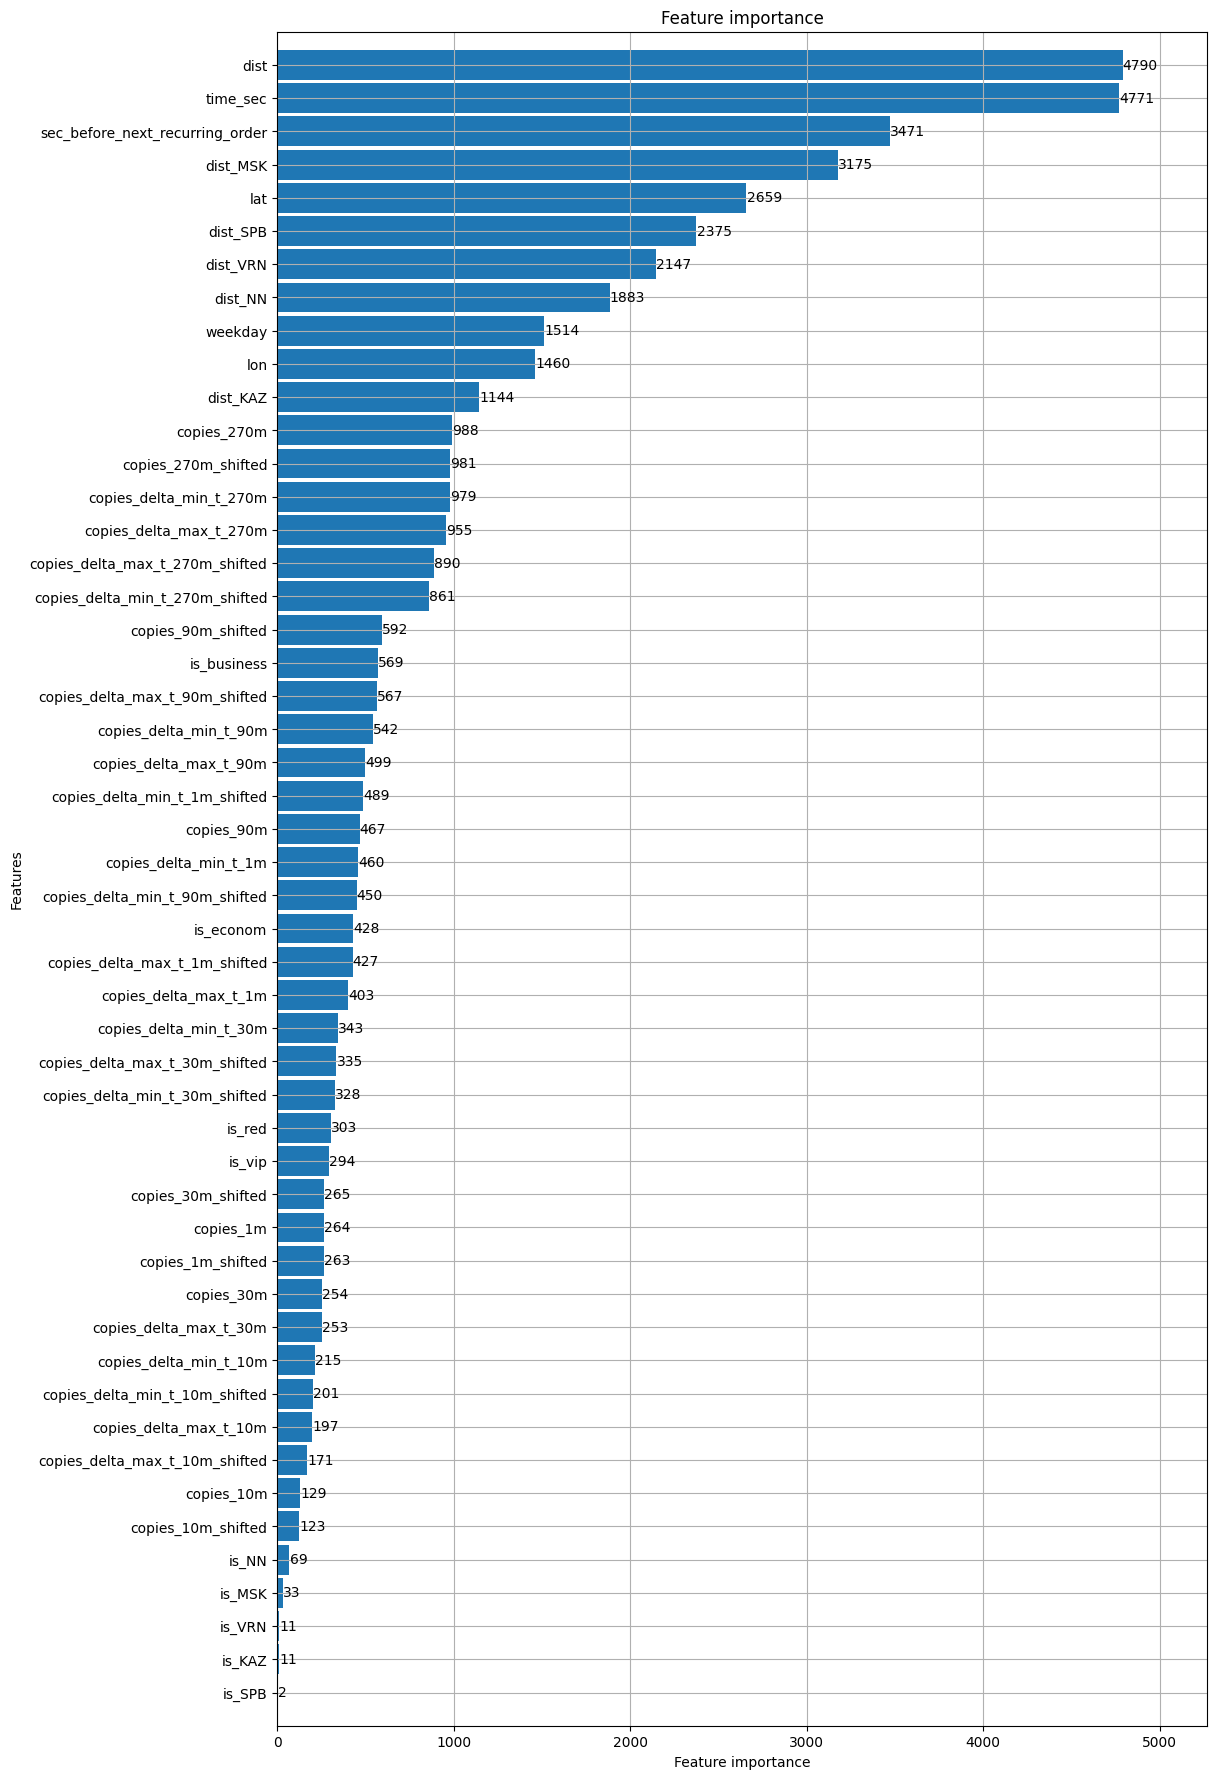

In [19]:
predictions = clf.predict_proba(data_final_test[feature_columns])

plt.rcParams["figure.figsize"] = (12, 22)

lightgbm.plot_importance(clf, max_num_features = 60, height=.9)

In [ ]:
# features = data[feature_columns].columns
# importances = clf.feature_importances_
# feature_importance = pd.DataFrame({'importance':importances,'features':features}).sort_values('importance', ascending=False).reset_index(drop=True)
# feature_importance
# clf.feature_importances_

In [20]:
# 14. Вывод результатов в файл

df = pd.DataFrame(data=(np.round(predictions[:, 1])).astype(int))
df.columns = ['target']
df.index.name = 'index'
df.to_csv('noKNN.csv')